In [0]:
# Digit Recognizer python.3
# -*- coding: utf-8 -*-
# @Time    : 22/9/2019 
# @Author  : Zhancheng Gan
# @File    : Digit_Recognizer.py
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, Convolution2D
from keras.optimizers import Adam, RMSprop
from keras.metrics import categorical_accuracy
from keras import regularizers

import tensorflow.compat.v1 as tf

import numpy as np
import random
import pandas as pd
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt

#connect google drive
from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#load data path
data_path = 'drive/My Drive/digit-recognizer.zip'
from zipfile import ZipFile 

zf = ZipFile(data_path)
zf.printdir()

train = pd.read_csv(zf.open('train.csv'))
test = pd.read_csv(zf.open('test.csv'))

File Name                                             Modified             Size
train.csv                                      2018-04-26 17:53:26     76775041
test.csv                                       2018-04-26 17:53:26     51118296
sample_submission.csv                          2018-04-26 17:53:24       240909


In [0]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

Y_train.value_counts()



1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [0]:
# Check for null and missing values
X_train.isnull().any().describe()
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [0]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [0]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [0]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 10)


In [0]:
# from sklearn.model_selection import train_test_split
# # Split the train and the validation set for the fitting
# X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.2, random_state=1211)

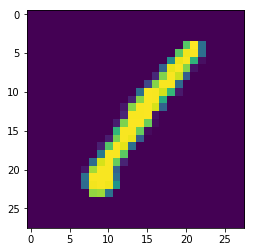

In [0]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

In [0]:
# ImageDataGenerator 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,
        validation_split=0.8
)  # randomly flip images

datagen.fit(X_train)
batch_size = 64
train_data = datagen.flow(
    X_train,
    Y_train,
    subset='training',
    batch_size=batch_size
)

validation_data = datagen.flow(
    X_train,
    Y_train,
    subset='validation',
    batch_size=batch_size
)


In [0]:
model = Sequential()

model.add(Conv2D(64, (5, 5), activation='relu',padding = 'Same',input_shape = (28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5, 5), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (5, 5), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


#add flatten layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
# model.summary()

#Set optimizer
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=True)
RMSprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
#model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
#add callback function
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

tbCallBack = TensorBoard(log_dir='log',histogram_freq=0,write_graph=True,write_images=False)
checkpoint = ModelCheckpoint(filepath='drive/My Drive/Colab Notebooks/model/best_aptos_model.hdf5',save_best_only='True',monitor='val_loss')
earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001)

callback = [tbCallBack,checkpoint,earlyStop,reduce_lr]


In [0]:
history = model.fit_generator(
        train_data,
        steps_per_epoch=len(train_data),
        verbose=1, 
        epochs=200,
        validation_data=validation_data,
        validation_steps=len(validation_data),
        callbacks=callback 
) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/200
132/132 [==============================] - 103s 784ms/step - loss: 1.4945 - categorical_accuracy: 0.4621 - val_loss: 0.4032 - val_categorical_accuracy: 0.8883
Epoch 2/200
132/132 [==============================] - 101s 765ms/step - loss: 0.3704 - categorical_accuracy: 0.8897 - val_loss: 0.1994 - val_categorical_accuracy: 0.9418
Epoch 3/200
132/132 [==============================] - 101s 763ms/step - loss: 0.2513 - categorical_accuracy: 0.9300 - val_loss: 0.1449 - val_categorical_accuracy: 0.9579
Epoch 4/200
132/132 [==============================] - 101s 766ms/step - loss: 0.1874 - categorical_accuracy: 0.9458 - val_loss: 0.1389 - val_categorical_accuracy: 0.9597
Epoch 5/200
132/132 [==============================] - 101s 767ms/step - loss: 0.1607 - categorical_accuracy: 0.9543 - val_loss: 0.1004 - val_categorical_accuracy: 0.9712
Epoch 6/200
132/132 [============================

In [0]:
# Model evaluation
# load the best model just saved
model.load_weights('drive/My Drive/Colab Notebooks/model/best_aptos_model.hdf5')
loss_and_metrics = model.evaluate_generator(validation_data,len(validation_data))
# print out the test result
print('Test loss:{}\nTest accuracy:{}'.format(loss_and_metrics[0], loss_and_metrics[1]))

Test loss:0.05020577809511451
Test accuracy:0.986547619047619


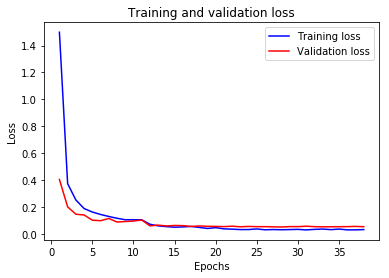

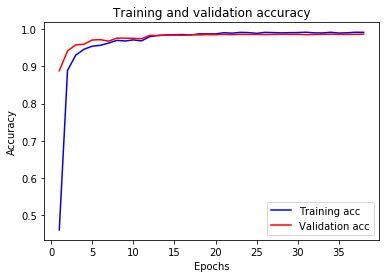

In [0]:
# model result visualization
history_dict = history.history

#plot the visualizations
import matplotlib.pyplot as plt

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf() 

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
from tqdm import tqdm
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(test)
    predictions.append(preds)

pred = np.mean(predictions, axis=0)


100%|██████████| 10/10 [05:22<00:00, 32.19s/it]


In [0]:
# predict results
#results = model.predict(test)
# select the indix with the maximum probability
results = np.argmax(pred,axis = 1)

sample = pd.read_csv(zf.open('sample_submission.csv'))
sample.Label = results.astype(int)
sample.to_csv("drive/My Drive/submission.csv", index=False)